In [23]:
%matplotlib inline
import os
import numpy as np

from copy import deepcopy
from scipy import interpolate

from matplotlib import pyplot as plt
from skimage.morphology import skeletonize_3d,dilation, binary_erosion


In [34]:
model_path = '/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/inference_results/unet3d_da_0.0nchannels4_r1_loss_dice_cut_z_False_full_run_only_w_labels_e80_lr_1e-3_AdamW_val_40/controls'

In [35]:
def nearest_neighbors(q,points,num_neighbors=2,exclude_self=True):
    d = ((points-q)**2).sum(axis=1)  # compute distances
    ndx = d.argsort() # indirect sort 
    start_ind = 1 if exclude_self else 0
    end_ind = start_ind+num_neighbors
    ret_inds = ndx[start_ind:end_ind]
    return ret_inds

In [36]:
def calc_angle(v1, v2, reflex=False):
    dot_prod = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    #round dot_prod for numerical stability
    angle = np.arccos(np.around(dot_prod,6))
    
    if (reflex == False):
        return angle
    else:
        return 2 * np.pi - angle

In [37]:
def order_points(candidate_points):
    ordered_points = []
    candidate_points = points
    #take first point
    ordered_points.append(candidate_points[0])
    nn = nearest_neighbors(ordered_points[-1], candidate_points,num_neighbors=1)
    #take second point
    ordered_points.append(candidate_points[nn[0]])
    #for ind,cp_i in enumerate(candidate_points):
    remove = 0
    while(len(ordered_points)<len(candidate_points)):
        
        #get 10 nearest neighbors of latest point
        nn = nearest_neighbors(ordered_points[-1], candidate_points,num_neighbors=10)
        # Taking the current point and the previous, we compute the angle to the current and eventual neighbourg
        # making sure its acute
        found = 0
        
        for cp_i in nn:
            ang = calc_angle(ordered_points[-2]-ordered_points[-1], candidate_points[cp_i]-ordered_points[-1])
            if ang > (np.pi/2.):
                found =1

                ordered_points.append(candidate_points[cp_i])
            if found == 1:
                break 
        if found ==0:
            if remove >5:
                break
            
            candidate_points = list(candidate_points)
            candidate_points = [arr for arr in candidate_points if not np.array_equal(arr, ordered_points[-1])]
            candidate_points = np.array(candidate_points)
            ordered_points.pop()
            remove += 1
    ordered_points = np.array(ordered_points)

    return(ordered_points)

In [59]:
n = 23
p = os.listdir(model_path)[n:n+1]

In [60]:
def skeleton_points(segmented, dilation_k=0, erosion_k = 0):
    # Average the segmentation over time (the geometry should be the same over time)
    avg = np.average(segmented, axis = 3)
    if dilation_k > 0:
        avg = binary_erosion(avg, selem=np.ones((erosion_k, erosion_k,erosion_k)))
        avg = dilation(avg, selem=np.ones((dilation_k, dilation_k,dilation_k)))
        
    # Compute the centerline points of the skeleton
    skeleton = skeletonize_3d(avg[:,:,:])
   
    # Get the points of the centerline as an array
    points = np.array(np.where(skeleton != 0)).transpose([1,0])

    # Order the points in ascending order with x
    points = points[points[:,0].argsort()[::-1]]
    
    return points
    

Loading subject 1 out of 28...
Patient's name: MACDAVD_155


/tmp/ipykernel_14226/2781398960.py:5: FutureWarning: `selem` is a deprecated argument name for `binary_erosion`. It will be removed in version 1.0. Please use `footprint` instead.
  avg = binary_erosion(avg, selem=np.ones((erosion_k, erosion_k,erosion_k)))
/tmp/ipykernel_14226/2781398960.py:6: FutureWarning: `selem` is a deprecated argument name for `dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  avg = dilation(avg, selem=np.ones((dilation_k, dilation_k,dilation_k)))


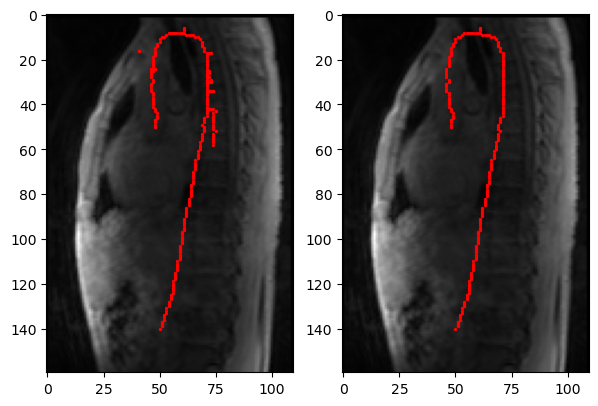

In [65]:
%matplotlib inline
path = model_path
cnn_predictions = True
img_path = '/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady/preprocessed/controls/numpy'

i = 0
for n, patient in enumerate(p):
    name = patient.replace("seg_", "").replace("_.npy", "")

    print("========================================================================")
    print('Loading subject ' + str(n+1) + ' out of ' + str(len(os.listdir(path))) + '...')
    print('Patient\'s name: ' + name)
    print("========================================================================")

    # load the segmentation that was created with Nicolas's tool
    image = np.load(img_path + f'/{patient.replace("seg_", "")}')
    segmented = np.load(path + f'/{patient}')
    
    points_ = skeleton_points(segmented, dilation_k = 0)
    points_dilated = skeleton_points(segmented, dilation_k = 5,erosion_k = 5)

    plt.close()
    fig, ax = plt.subplots(1, 2, figsize=(7, 7))
    axs = ax.ravel()
    axs[0].imshow(image[:,:,15,3,0], cmap='gray')
    axs[0].scatter(points_[:,1],points_[:,0], s=2, c='red', marker='o')
    
    axs[1].imshow(image[:,:,15,3,0], cmap='gray')
    axs[1].scatter(points_dilated[:, 1],points_dilated[:,0], s=2, c='red', marker='o')    
    plt.show()
    points = points_dilated
    points = points[points[:,0].argsort()[::-1]]

In [66]:
ordered_points = []
candidate_points = points
#take first point
ordered_points.append(candidate_points[0])
nn = nearest_neighbors(ordered_points[-1], candidate_points,num_neighbors=1)
#take second point
ordered_points.append(candidate_points[nn[0]])
print(len(ordered_points))
#for ind,cp_i in enumerate(candidate_points):
remove = 0
while(len(ordered_points)<len(candidate_points)):
    print(len(ordered_points), '/', len(candidate_points))
    #get 10 nearest neighbors of latest point
    nn = nearest_neighbors(ordered_points[-1], candidate_points,num_neighbors=10)
    print(nn)
    # Taking the current point and the previous, we compute the angle to the current and eventual neighbourg
    # making sure its acute
    found = 0
    
    for cp_i in nn:
        ang = calc_angle(ordered_points[-2]-ordered_points[-1], candidate_points[cp_i]-ordered_points[-1])
        print(ang)
        # Check 
         
        #if ang > np.pi/2.:
        if ang > (np.pi/2.):
            found =1

            ordered_points.append(candidate_points[cp_i])
        if found == 1:
            break 
    if found ==0:
        if remove >5:
            break
        
        candidate_points = list(candidate_points)
        candidate_points = [arr for arr in candidate_points if not np.array_equal(arr, ordered_points[-1])]
        candidate_points = np.array(candidate_points)
        ordered_points.pop()
        remove += 1
ordered_points = np.array(ordered_points)


2
2 / 190
[ 2  0  3  4  5  6  7  8  9 10]
2.356194799641345
3 / 190
[ 1  3  0  4  5  6  7  8  9 10]
0.0
3.141592653589793
4 / 190
[ 2  4  1  5  0  6  7  8  9 10]
0.0
2.356194799641345
5 / 190
[ 5  3  6  2  1  7  8  0  9 10]
2.356194799641345
6 / 190
[ 4  6  3  7  2  8  1  9  0 10]
0.0
3.141592653589793
7 / 190
[ 5  7  4  8  3  9  2 10  1 11]
0.0
2.356194799641345
8 / 190
[ 8  6  9  5 10  4 11  3 12  2]
2.356194799641345
9 / 190
[ 7  9 10  6  5 11  4 12  3 13]
0.0
3.141592653589793
10 / 190
[ 8 10  7 11  6 12  5 13  4 14]
0.0
2.356194799641345
11 / 190
[11  9 12  8  7 13 14  6 15  5]
2.356194799641345
12 / 190
[10 12 13  9  8 14  7 15  6 16]
0.0
3.141592653589793
13 / 190
[11 13 10 14 15  9  8 16  7 17]
0.0
2.356194799641345
14 / 190
[14 12 15 11 10 16 17  9 18  8]
2.356194799641345
15 / 190
[13 15 16 12 11 17 10 18 19  9]
0.0
3.141592653589793
16 / 190
[14 16 13 17 12 18 19 11 20 10]
0.0
2.356194799641345
17 / 190
[15 17 18 14 19 13 20 12 21 11]
0.0
2.0943951023931957
18 / 190
[18 16 1

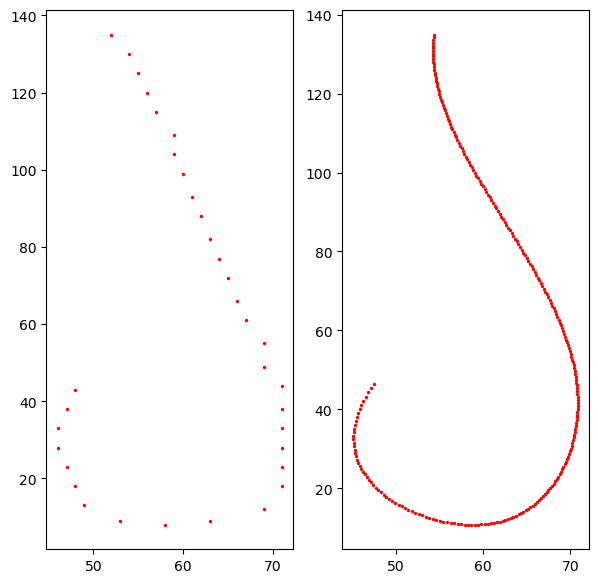

In [67]:
points_order = order_points(points)
temp = []
for index, element in enumerate(points_order[5:]):
    if (index%5)==0:
        temp.append(element)

coords = np.array(temp)
#print(coords_limited)



x = coords[:,0]
y = coords[:,1]
z = coords[:,2]
coords = np.array([z,y,x]).transpose([1,0])
size = [36, 36, 256, 48, 4] # [x, y, z, t, num_channels]


# spline parametrization
params = [i / (size[2] - 1) for i in range(size[2])]
tck, _ = interpolate.splprep(np.swapaxes(coords, 0, 1), k=3, s=200)
points_inter = np.swapaxes(interpolate.splev(params, tck, der=0), 0, 1)

fig, ax = plt.subplots(1, 2, figsize=(7, 7))
axs = ax.ravel()
axs[0].scatter(coords[:,1],coords[:,2], s=2, c='red', marker='o')


axs[1].scatter(points_inter[:, 1],points_inter[:,2], s=2, c='red', marker='o')

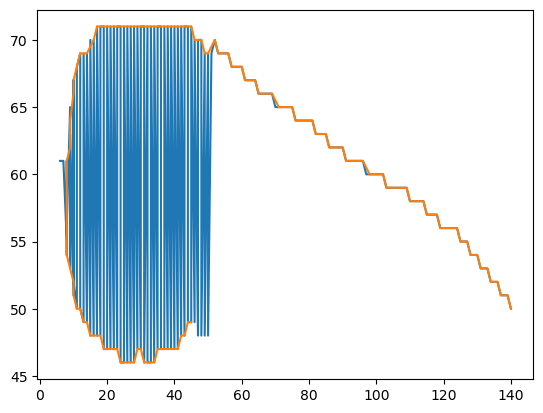

In [68]:
#j = 0
#ordered_points_ = order_points(points)
plt.plot(points[:,0],points[:,1])
plt.plot(ordered_points[:,0],ordered_points[:,1])
#plt.plot(ordered_points[j:j+10,0],ordered_points[j:j+10,1])

In [16]:
def clean_points(points, descend_pt, ascend_pt):
    candidate_points = deepcopy(points)
    del_inds = [1]#temporary
    while len(del_inds)>0:
        del_inds = []
        for ind,cp_i in enumerate(candidate_points):
            #get two nearest neighbors
            nn = nearest_neighbors(cp_i, candidate_points)
            ang = calc_angle(candidate_points[nn[0]]-cp_i,
                             candidate_points[nn[1]]-cp_i)
            if ang < np.pi/2.:
                #if acute angle, delete point
                #assumes trajectory should never have turns sharper than 90deg
                if not np.array_equal(cp_i, descend_pt) and not np.array_equal(cp_i, ascend_pt):
                    #do not delete main end points
                    del_inds.append(ind)

        mask = np.ones(len(candidate_points))
        mask[del_inds]=0
        mask = mask.astype(bool)
        #get rid of delete indices
        candidate_points = candidate_points[mask]
        
    return candidate_points
def start_finish_point(points):
    #sort first (already done above)
    #points = points[points[:,0].argsort()[::-1]]
    descend_ind = 0 #assume lowest point
    descend_pt = points[descend_ind]

    #before top of aorta
    # We get the tallest point and then I add the quadret 
    #ascend_half = points[points[:,1]<points[-1][1]] # Jerem
    ascend_half = points[(points[:,1]<points[-1][1]) & (points[:,0] <80)]
    #print(ascend_half)
    #center of mass of ascending aorta
    ctr_mass = ascend_half.mean(axis=0)
    #points before the center of mass of ascending aorta
    before_ctr = ascend_half[ascend_half[:,1]<ctr_mass[1]]
    #print(ctr_mass)
    #ascending coord
    ascend_pt = before_ctr[before_ctr[:,0].argsort()[-1]]
    #find index
    ascend_ind = nearest_neighbors(ascend_pt,points,num_neighbors=1,exclude_self=False)[0]
    plt.plot(points[:,0],points[:,1])
    plt.scatter(points[descend_ind,0],points[descend_ind,1],c='r')
    plt.scatter(points[ascend_ind,0],points[ascend_ind,1],c='g')
    plt.show()
    candidate_points = clean_points(points, descend_pt, ascend_pt)
    plt.scatter(points[:,0],points[:,1])
    plt.scatter(candidate_points[:,0],candidate_points[:,1])
    plt.show()



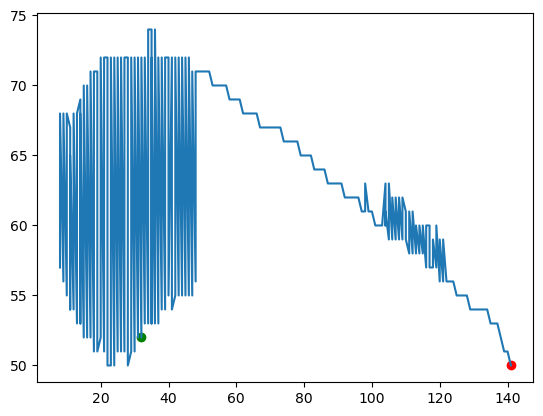

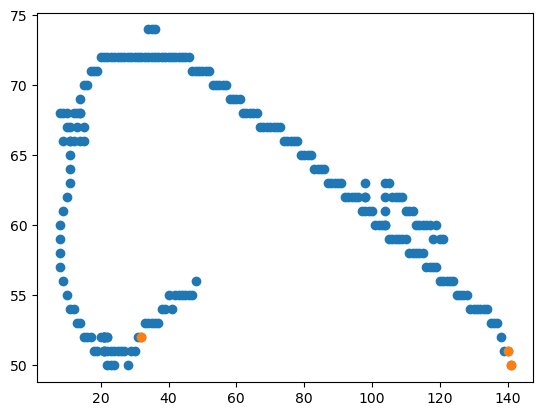

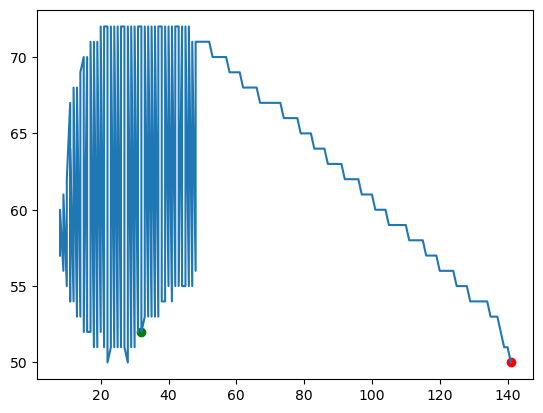

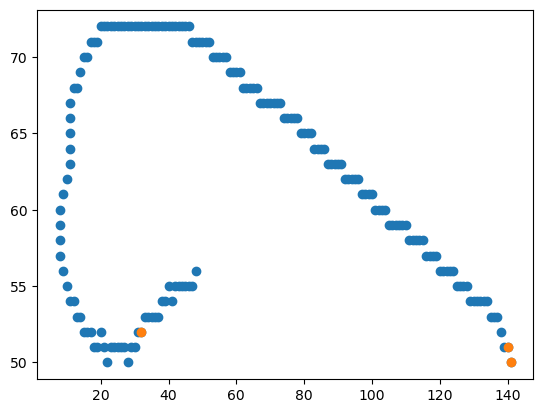

In [17]:
start_finish_point(points_)
start_finish_point(points_dilated)

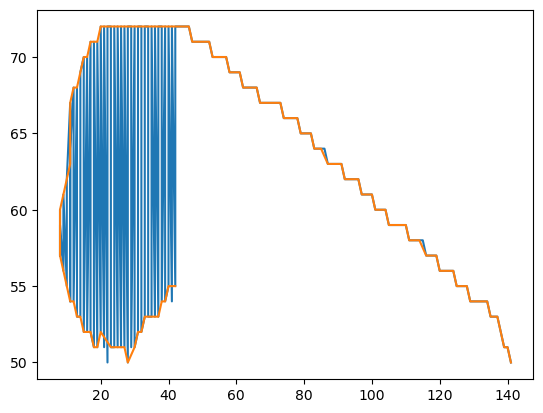

In [18]:
#j = 0
ordered_points = order_points(candidate_points)
plt.plot(candidate_points[:,0],candidate_points[:,1])
plt.plot(ordered_points[:,0],ordered_points[:,1])
#plt.plot(ordered_points[j:j+10,0],ordered_points[j:j+10,1])

## Rough

In [57]:
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [86]:
nearest_neighbors(ascend_pt,points)

array([72, 74])

In [87]:
q = ascend_pt
d = ((points-q)**2).sum(axis=1)  # compute distances
ndx = d.argsort() # indirect sort 

In [90]:
points[70]

array([70, 47, 29])

In [22]:
q = points[5]
d = ((points-q)**2).sum(axis=1)  # compute distances
ndx = d.argsort() # indirect sort 

In [88]:
ndx

array([ 70,  72,  74,  76,  77,  79,  84,  87,  88,  93,  96,  97, 102,
       105, 106, 111, 114, 116, 119, 123, 126, 132, 140,  63,  67,  69,
        68,  71,  73,  66,  75, 143,  65,  61,  64,  56,  60,  57,  62,
        59,  55,  78,  58,  54,  80,  82, 144,  85,  90,  53,  51,  91,
       149,  52,  94,  50,  99, 152, 100,  48,  49, 103, 155,  47, 108,
       109,  46,  45, 157, 112,  44, 159, 165, 117,  43, 120,  42, 121,
        41, 173, 124,  40, 127, 131, 130, 129, 176,  81,  39, 179, 138,
       133, 134,  38, 141,  83,  86, 183, 135, 136,  89,  37, 146,  92,
        95, 186,  98, 147,  36, 137, 101, 104,  35, 150, 107, 189, 153,
       193,  34,  33, 110, 158, 113, 196, 115, 160,  32, 122, 118, 166,
       162, 197, 163, 125,  31, 128, 170, 201, 169, 171,  30, 168, 167,
       174, 209,  29, 180, 211, 139, 184,  28, 145, 142, 177, 187, 148,
       217,  27, 178, 151, 188, 219,  26, 154, 191, 234, 156,  25, 194,
       161, 164, 235, 198,  24, 172, 243, 202,  23, 175, 181, 20

In [31]:
closest = points[ndx[1:10]]

In [32]:
len(points)

316

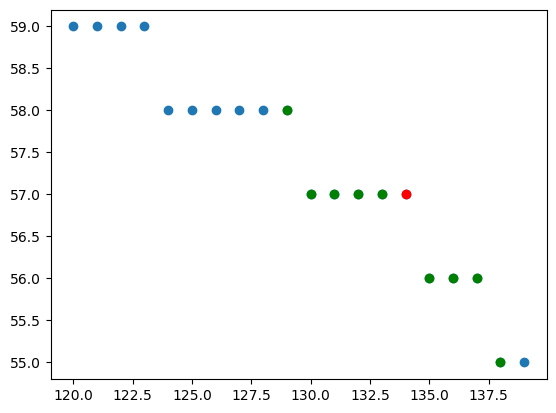

In [35]:
plt.scatter(points[:20,0],points[:20,1])
plt.scatter(points[5,0],points[5,1],c='r')
plt.scatter(closest[:,0],closest[:,1],c='g')


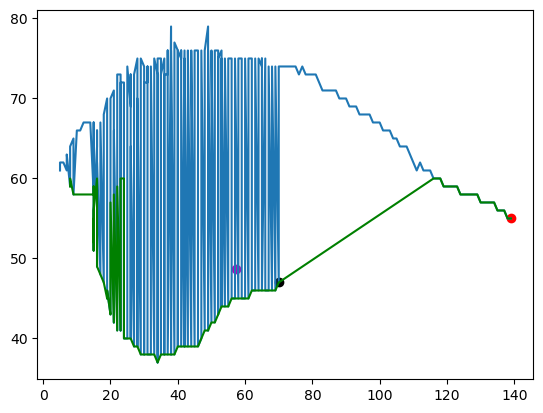

In [72]:
plt.plot(points[:,0],points[:,1])
plt.scatter(points[0,0],points[0,1],c='r')
plt.plot(ascend_half[:,0],ascend_half[:,1],c='g')
plt.scatter(ctr[0],ctr[1],c='m')
plt.scatter(ascend_pt[0],ascend_pt[1],c='k')
#plt.scatter(points[-1,0],points[-1,1],c='r')

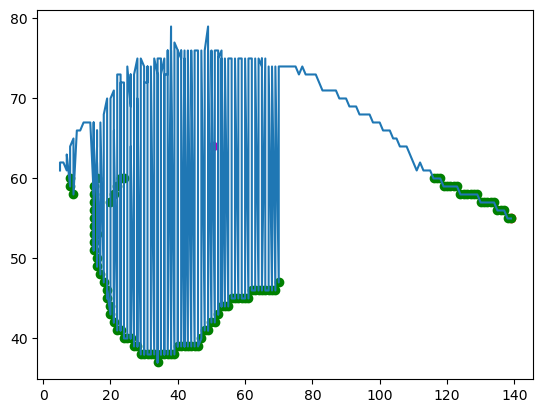

In [60]:
plt.plot(points[:,0],points[:,1])
plt.scatter(points[0,0],points[0,1],c='r')
plt.scatter(ascend_half[:,0],ascend_half[:,1],c='g')
plt.scatter(ctr[0],ctr[1],c='m')
#plt.scatter(points[-1,0],points[-1,1],c='r')

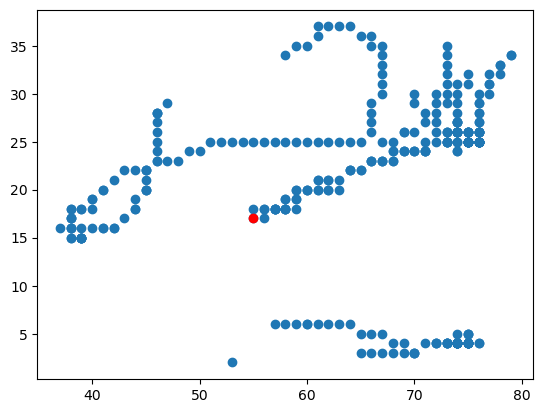

In [17]:
plt.scatter(points[:,1],points[:,2])
plt.scatter(points[0,1],points[0,2],c='r')

In [7]:
points[0]

array([139,  55,  17])

In [ ]:
angle obtuse